In [1]:
import os 
if 'notebooks' in os.getcwd():
    os.chdir("..")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv(
    "data/round4/prices_round_4_day_3.csv",
    sep = ';'
)

In [3]:
data

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,3,0,PICNIC_BASKET,73997.0,2.0,73996.0,14.0,73994.0,30.0,74008.0,2.0,74009.0,14.0,74010.0,30.0,74002.5,0.0
1,3,0,DOLPHIN_SIGHTINGS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3094.0,0.0
2,3,0,BERRIES,3905.0,14.0,3904.0,52.0,NaN,NaN,3912.0,14.0,3913.0,52.0,NaN,NaN,3908.5,0.0
3,3,0,BAGUETTE,12381.0,47.0,12380.0,56.0,NaN,NaN,12383.0,103.0,NaN,NaN,NaN,NaN,12382.0,0.0
4,3,0,PEARLS,9996.0,2.0,9995.0,25.0,NaN,NaN,10004.0,2.0,10005.0,25.0,NaN,NaN,10000.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109995,3,999900,BANANAS,4749.0,2.0,4748.0,23.0,NaN,NaN,4753.0,1.0,4755.0,25.0,NaN,NaN,4751.0,176712.0
109996,3,999900,PEARLS,9996.0,2.0,9995.0,23.0,NaN,NaN,9998.0,1.0,10002.0,5.0,10004.0,2.0,9997.0,0.0
109997,3,999900,DIVING_GEAR,100295.0,24.0,NaN,NaN,NaN,NaN,100298.0,24.0,NaN,NaN,NaN,NaN,100296.5,-231552.0
109998,3,999900,BERRIES,3829.0,18.0,3828.0,58.0,NaN,NaN,3836.0,18.0,3837.0,58.0,NaN,NaN,3832.5,319238.0


In [4]:
dip = data.query("product == 'DIP'")\
    .set_index("timestamp")
baguette = data.query("product == 'BAGUETTE'")\
    .set_index("timestamp")
ukulele = data.query("product == 'UKULELE'")\
    .set_index("timestamp")
picnic_basket = data.query("product == 'PICNIC_BASKET'")\
    .set_index("timestamp")

# Correlation 

In [5]:
basket_separated = (ukulele + 4*dip + 2*baguette) \
    .mid_price

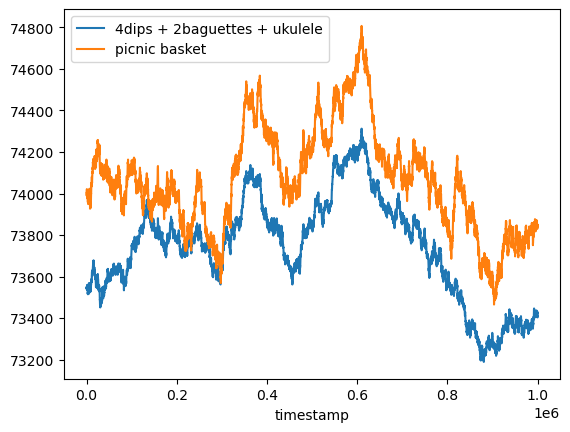

In [6]:
basket_separated.plot(
    label = '4dips + 2baguettes + ukulele'
)

picnic_basket\
    .mid_price\
    .plot(
        label = 'picnic basket'
    )

plt.legend()

In [7]:
basket_separated.corr(
    picnic_basket.mid_price
)

0.8561848829668195

In [8]:
spread = picnic_basket.mid_price - basket_separated

<AxesSubplot:xlabel='timestamp'>

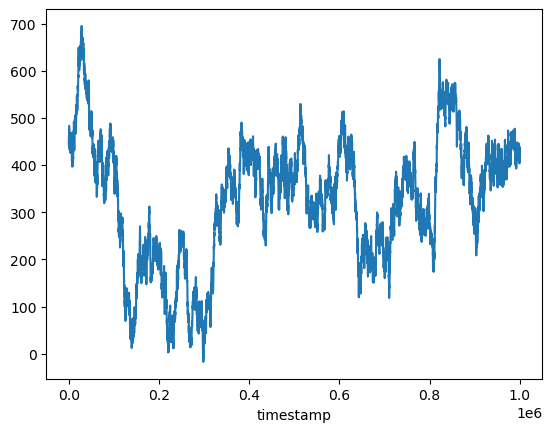

In [9]:
spread.plot()

In [10]:
window = 200

avg_rolling_spread = spread.rolling(window)\
    .mean()

mov_spread5 = spread.rolling(5).mean()

rolling_std_spread = spread.rolling(window)\
    .std()


In [11]:
zscore_spread = (mov_spread5 - avg_rolling_spread)/rolling_std_spread

<AxesSubplot:xlabel='timestamp'>

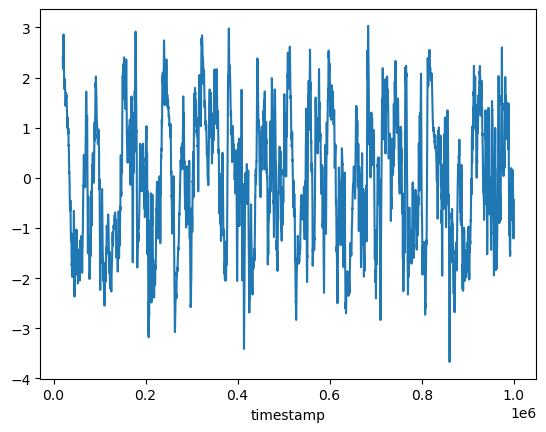

In [12]:
zscore_spread.plot()

In [13]:
buy = zscore_spread < -2
sell = zscore_spread > 2

(0.0, 1000000.0)

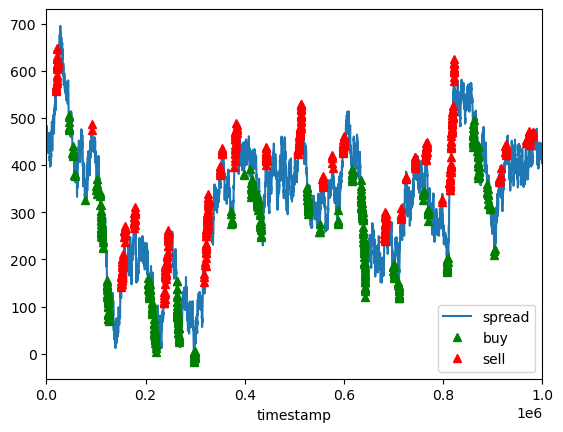

In [14]:
spread.plot(label = 'spread')
spread[buy].plot(
    marker ='^', 
    color ='green', 
    linestyle= 'None',
    label = 'buy'
)
spread[sell].plot(
    marker= '^', 
    color = 'red', 
    linestyle= 'None',
    label = 'sell'
)

plt.legend()
plt.xlim([0, 1e6])

In [15]:
spread[sell].shape, spread[buy].shape

((567,), (570,))

In [16]:
position_size = (spread[buy].shape[0] - spread[sell].shape[0])

In [17]:
pnl = (spread[sell].sum() - spread[buy].sum() - position_size*spread.iloc[-1])

In [18]:
cash = pd.concat([spread[sell], -spread[buy]])\
    .sort_index()\
    .cumsum()\
    .reindex(picnic_basket.index)\
    .fillna(method="ffill")

In [19]:
position = pd.Series(0, index = picnic_basket.index)

In [20]:
for idx, value in spread[sell].items():
    position.loc[idx] = -1

for idx, value in spread[buy].items():
    position.loc[idx] = 1

position = position.cumsum()

In [21]:
value_on_position = (position * spread)\
    .reindex(picnic_basket.index)\
    .fillna(method="ffill")

In [22]:
pnl = value_on_position + cash

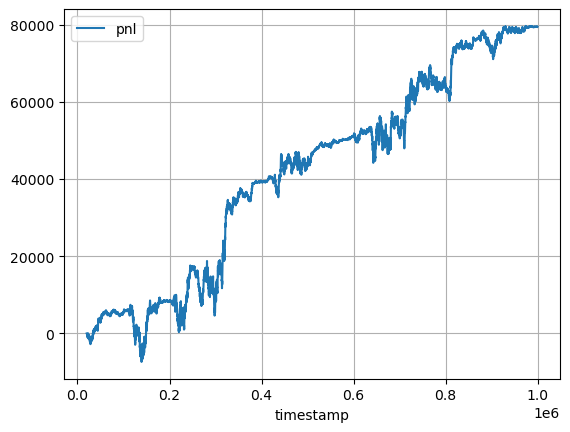

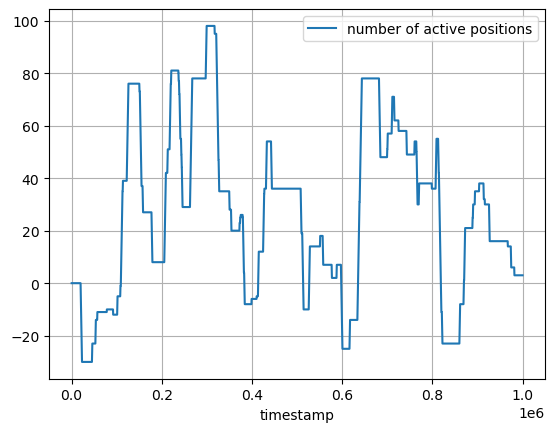

In [23]:
pnl.plot(
    label = "pnl"
)
plt.grid()
plt.legend()

plt.figure()
position.plot(
    label = "number of active positions"
)
plt.grid()
plt.legend()

In [24]:
sharpe = pnl.mean()/pnl.std()
sharpe

1.580042725718461